# <center> Predicting Flight Ticket Prices </center>

# Table of Contents:
* ## [Introduction](#introduction)

* ## [Scraped Data EDA](#eda)

* ## [Handling Categorical Data](#cat_data)

* ## [Features](#features)

* ## [Modeling](#modeling)

* ## [Saving The Final Model](#model)

## Introduction: <a class="anchor" id="introduction"></a>

<b> This is the main notebook for the flight price prediction project. We predict ticket prices for upcoming flights to help customers in selecting the optimum time for travel and the cheapest flight to the desired destination. The data of the project which is used to train the models is scraped from [Kayak](http://www.kayak.com) which is detailed in the "kayak-scraper" notebook. </b>

### Importing necessarry libraries

In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

sns.set()

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn import metrics

## Scraped Data EDA: <a class="anchor" id="eda"></a>
### Loading the scraped data

In [119]:
df_1 = pd.read_csv("data/PAR_NYC.csv")
df_2 = pd.read_csv("data/PAR_SVO.csv")
df_3 = pd.read_csv("data/SVO_NYC.csv")
df_4 = pd.read_csv("data/SVO_RUH.csv")
df_5 = pd.read_csv("data/NYC_PAR.csv")
df_6 = pd.read_csv("data/NYC_SVO.csv")
df_7 = pd.read_csv("data/RUH_NYC.csv")
df_8 = pd.read_csv("data/RUH_PAR.csv")
df_9 = pd.read_csv("data/RUH_SVO.csv")
df_10 = pd.read_csv("data/SVO_PAR.csv")
df_11 = pd.read_csv("data/PAR_RUH.csv")
df_12 = pd.read_csv("data/NYC_RUH.csv")

In [120]:
print(f"{df_1['Source'][0]} => {df_1['Destination'][0]} route has {df_1.shape[0]} trips")
print(f"{df_2['Source'][0]} => {df_2['Destination'][0]} route has {df_2.shape[0]} trips")
print(f"{df_3['Source'][0]} => {df_3['Destination'][0]} route has {df_3.shape[0]} trips")
print(f"{df_4['Source'][0]} => {df_4['Destination'][0]} route has {df_4.shape[0]} trips")
print(f"{df_5['Source'][0]} => {df_5['Destination'][0]} route has {df_5.shape[0]} trips")
print(f"{df_6['Source'][0]} => {df_6['Destination'][0]} route has {df_6.shape[0]} trips")
print(f"{df_7['Source'][0]} => {df_7['Destination'][0]} route has {df_7.shape[0]} trips")
print(f"{df_8['Source'][0]} => {df_8['Destination'][0]} route has {df_8.shape[0]} trips")
print(f"{df_9['Source'][0]} => {df_9['Destination'][0]} route has {df_9.shape[0]} trips")
print(f"{df_10['Source'][0]} => {df_10['Destination'][0]} route has {df_10.shape[0]} trips")
print(f"{df_11['Source'][0]} => {df_11['Destination'][0]} route has {df_11.shape[0]} trips")
print(f"{df_12['Source'][0]} => {df_12['Destination'][0]} route has {df_12.shape[0]} trips")

PAR => NYC route has 14881 trips
PAR => SVO route has 2403 trips
SVO => NYC route has 4202 trips
SVO => RUH route has 2235 trips
NYC => PAR route has 5334 trips
NYC => SVO route has 1905 trips
RUH => NYC route has 7279 trips
RUH => PAR route has 553 trips
RUH => SVO route has 2725 trips
SVO => PAR route has 3314 trips
PAR => RUH route has 7327 trips
NYC => RUH route has 3205 trips


### Defining functions to clean the data

In [121]:
# convert duration to numerical format in minutes
def clean_duration(duration):
    duration = list(duration)
    duration_hours = []
    duration_mins = []
    for i in range(len(duration)):
        duration_hours.append(int(duration[i].split(sep = "h")[0])) # Extract hours from duration
        duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1])) # Extracts only minutes from duration

    d = []
    for i in range(len(duration)):
        d.append(duration_hours[i]*60+duration_mins[i])
        
    return d

# convert price to numerical format in USD
def clean_price(price):
    price = price.str.replace(',','',regex=True)
    price = price.str.replace('SAR','',regex=True)
    price = price.str.strip()
    price = round(pd.to_numeric(price)/3.75,2)
    return price

# convert date to datetime format
def clean_date(date):
    date = pd.to_datetime(date)
    return date

# get price quantile to deal with outliers
def get_price_quantile(price):
    Q1 = price.quantile(0.25)
    Q3 = price.quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    return (lower_lim,upper_lim)

# get average of each airline
def get_avg_per_airline(x):
    # average for trips with multiple airlines
    multiple_airlines = x[x["Airline"].str.contains(",")]
    b = list(multiple_airlines["Airline"].str.split(","))
    d = [] # Airline 1
    e = [] # Airline 2
    for i in range(len(b)):
        d.append(b[i][0])
        e.append(b[i][1])
    for i in range(len(e)):
        e[i] = e[i].strip()
    m_airlines = list(set(d)) + list(set(e))
    column_names = ["Airline", "Average Price"]
    t_ = pd.DataFrame(columns = column_names)
    for airline in m_airlines:
        t = pd.DataFrame(x[x["Airline"].str.contains(airline)]["Airline"])
        t["Average Price"] = x[x["Airline"].str.contains(airline)]["Price"].mean()
        t_ = t_.append(t)
    t__ = t_.groupby("Airline",as_index = False)["Average Price"].mean()
    k = multiple_airlines.copy()
    k = k.merge(t__, on = "Airline", how = "left")
    
    # average for trips with single airlines
    single_airlines = x[~x["Airline"].str.contains(",")]
    avg_per_airline = single_airlines.groupby("Airline", as_index = False)["Price"].mean()
    avg_per_airline = avg_per_airline.rename(columns={"Price" : "Average Price"})
    temp = single_airlines.copy()
    temp = temp.merge(avg_per_airline, on='Airline', how ="left")
    
    temp_1 = temp.groupby("Airline", as_index = False)["Average Price"].mean()
    k_1 = k.groupby("Airline", as_index = False)["Average Price"].mean()
    k_temp = pd.concat([k_1,temp_1])
    y = x.merge(k_temp, on = "Airline")
    
    return y


In [122]:
dfs_raw = [df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10,df_11,df_12]

In [123]:
# cleaning the data
dfs = []
for df in dfs_raw:
    df.drop_duplicates() # drop duplicate rows
    df["Duration"] = clean_duration(df["Duration"]) # convert duration to numerical minutes format
    df["Price"] = clean_price(df["Price"]) # convert price to numerical format in USD
    df["Date"] = clean_date(df["Date"]) # convert date to datetime format
    dfs.append(get_avg_per_airline(df)) # get average per airline


### Studying outliers

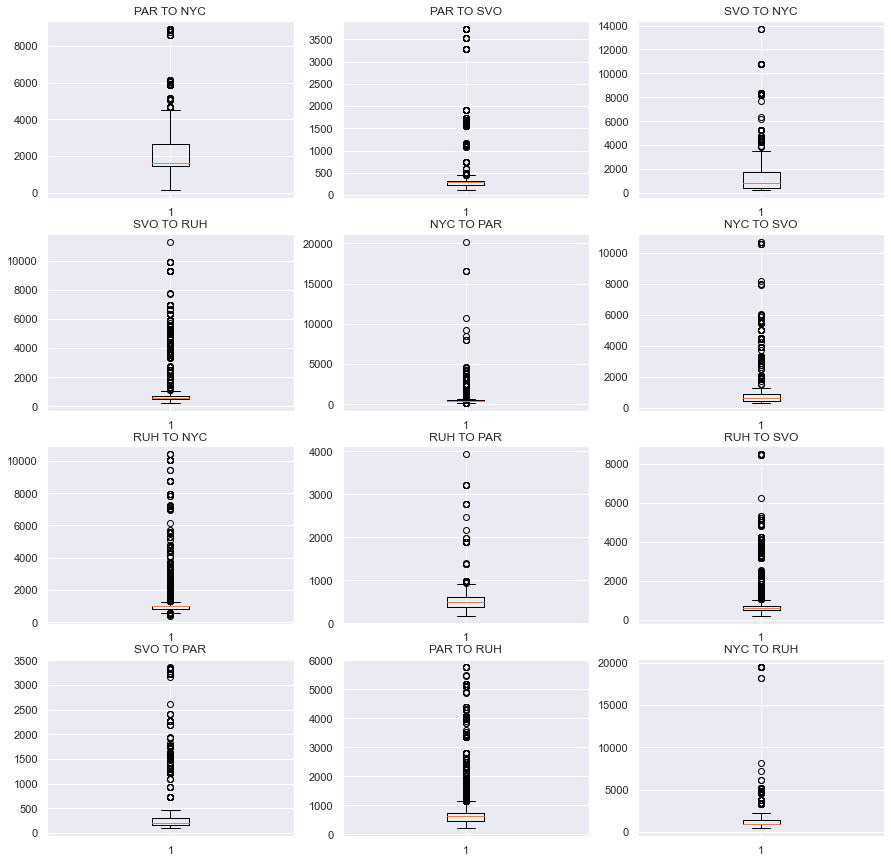

In [124]:
# boxplots for each route
k=0
figure, axis = plt.subplots(4, 3, figsize=(15,15))
for i in range(4):
    for j in range(3):
        axis[i,j].boxplot(dfs[k]['Price'])
        axis[i,j].set_title(f"{dfs[k]['Source'][0]} TO {dfs[k]['Destination'][0]}")
        k += 1

#### It is apparent that all routes have outliers, so we'll deal with them by IQR

In [125]:
# get quantile to deal with outliers
lower = []
upper = []
for df in dfs:
    x = get_price_quantile(df['Price'])
    lower.append(x[0])
    upper.append(x[1])

In [126]:
# drop outliers
k = 0
for df in dfs:
    low = df['Price'] < lower[k]
    up = df['Price'] > upper[k]
    df['Price'] = df['Price'][~(low|up)]
    df.dropna(inplace=True)
    df.reset_index(drop = True,inplace=True)
    k+=1

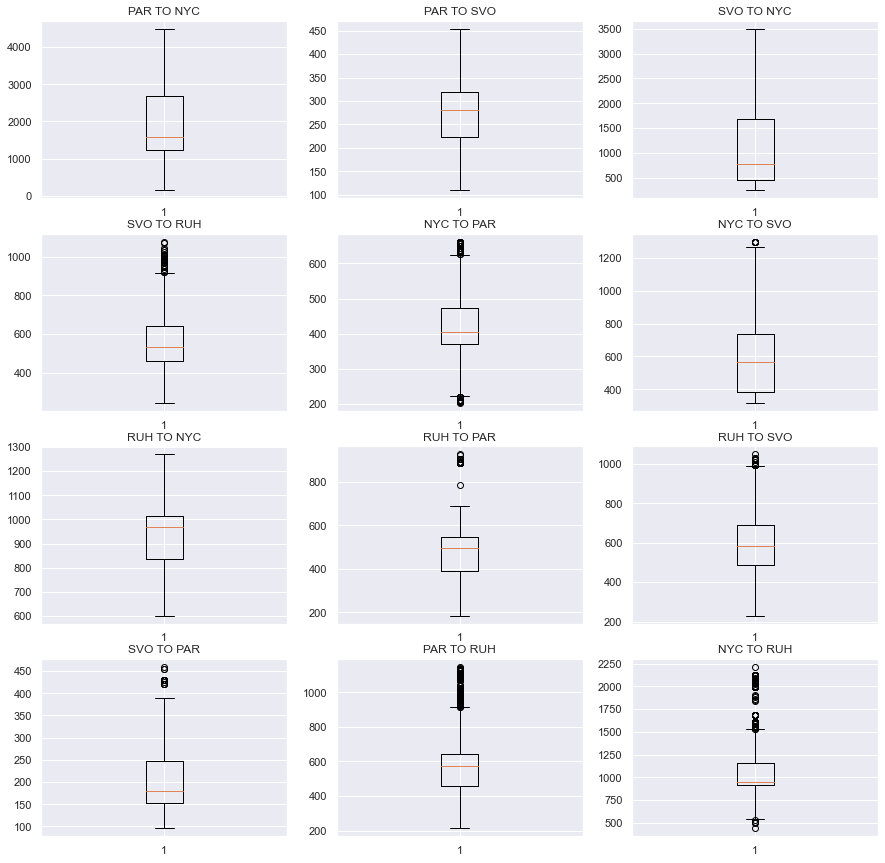

In [127]:
# boxplot for each route after dealing with outliers
k=0
figure, axis = plt.subplots(4, 3, figsize=(15,15))
for i in range(4):
    for j in range(3):
        axis[i,j].boxplot(dfs[k]['Price'])
        axis[i,j].set_title(f"{dfs[k]['Source'][0]} TO {dfs[k]['Destination'][0]}")
        k += 1

#### Now the data is much better, the total dropped data is 5,266 rows out of 55,363.

In [128]:
# concat all routes into one dataframe
df = pd.concat(dfs)
df

,Airline,Source,Destination,Duration,Total stops,Price,Date,Average Price
0,TAP AIR PORTUGAL,PAR,NYC,770,1 stop,379.47,2022-02-01,441.343760
1,TAP AIR PORTUGAL,PAR,NYC,770,1 stop,379.47,2022-02-01,441.343760
2,TAP AIR PORTUGAL,PAR,NYC,810,1 stop,379.47,2022-02-01,441.343760
3,TAP AIR PORTUGAL,PAR,NYC,890,1 stop,379.47,2022-02-01,441.343760
4,TAP AIR PORTUGAL,PAR,NYC,1030,1 stop,379.47,2022-02-01,441.343760
...,...,...,...,...,...,...,...,...
3046,"SAS, Pegasus Airlines",NYC,RUH,1300,2 stops,930.40,2022-04-13,838.732500
3047,"Qatar Airways, SAUDIA",NYC,RUH,1420,2 stops,1018.40,2022-04-13,1972.813714
3048,"Qatar Airways, MEA",NYC,RUH,1415,2 stops,1049.87,2022-04-13,1133.548015
3049,"Emirates, Turkish Airlines",NYC,RUH,1100,2 stops,1053.60,2022-04-13,1023.900221


In [129]:
# check for null values
df.isnull().sum()

Airline          0
Source           0
Destination      0
Duration         0
Total stops      0
Price            0
Date             0
Average Price    0
dtype: int64

## Handling Categorical Data: <a class="anchor" id="cat_data"></a>


In [130]:
# the Airline column will be replaced by the average price per airline.
df.drop("Airline", axis = 1, inplace = True)

In [131]:
# source
df["Source"].value_counts()

PAR    23054
NYC     9411
RUH     9140
SVO     8492
Name: Source, dtype: int64

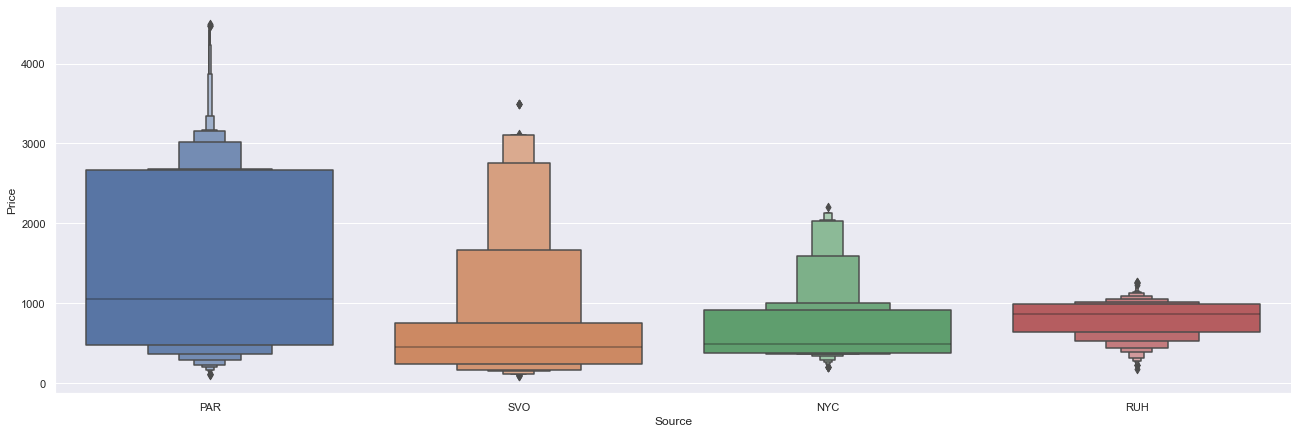

In [132]:
# source vs price
sns.catplot(y = "Price", x= "Source", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)

In [133]:
# performing OneHotEncoding on Source since it's nominal categorical data  
source =df[["Source"]]
source =pd.get_dummies(source, drop_first=True)
source.head()

,Source_PAR,Source_RUH,Source_SVO
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [134]:
# destination
df["Destination"].value_counts()

NYC    24926
RUH    11046
PAR     8042
SVO     6083
Name: Destination, dtype: int64

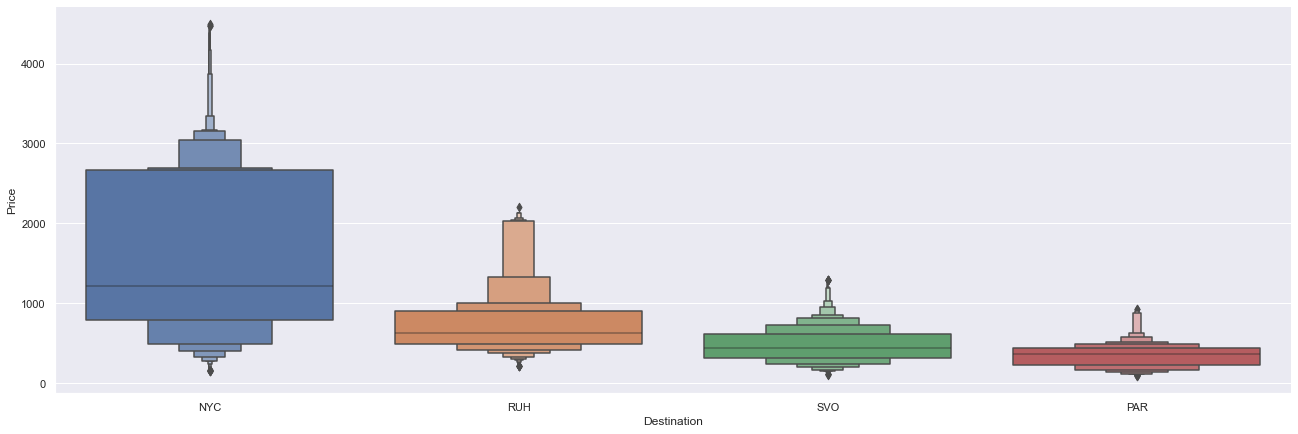

In [136]:
# destination vs price
sns.catplot(y = "Price", x= "Destination", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)

In [154]:
# performing OneHotEncoding on Destination since it's nominal categorical data
destination = df[["Destination"]]
destination = pd.get_dummies(destination, drop_first=True)
destination.head()

,Destination_PAR,Destination_RUH,Destination_SVO
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [140]:
# total stops
print(df["Total stops"].value_counts())
df["Total stops"].unique()

1 stop      27466
2 stops     18665
3 stops      1988
nonstop      1978
Name: Total stops, dtype: int64


array(['1 stop ', '2 stops ', 'nonstop ', '3 stops '], dtype=object)

In [141]:
# performing LabelEncoder on Total stops since it's ordinal categorical data
df.replace({"nonstop ":0, "1 stop ": 1, "2 stops ": 2, "3 stops ":3}, inplace=True)

In [149]:
final_df = pd.concat([df,source,destination], axis=1).reset_index(drop = True)

In [150]:
final_df

,Source,Destination,Duration,Total stops,Price,Date,Average Price,Source_PAR,Source_RUH,Source_SVO,Destination_PAR,Destination_RUH,Destination_SVO
0,PAR,NYC,770,1,379.47,2022-02-01,441.343760,1,0,0,0,0,0
1,PAR,NYC,770,1,379.47,2022-02-01,441.343760,1,0,0,0,0,0
2,PAR,NYC,810,1,379.47,2022-02-01,441.343760,1,0,0,0,0,0
3,PAR,NYC,890,1,379.47,2022-02-01,441.343760,1,0,0,0,0,0
4,PAR,NYC,1030,1,379.47,2022-02-01,441.343760,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50092,NYC,RUH,1300,2,930.40,2022-04-13,838.732500,0,0,0,0,1,0
50093,NYC,RUH,1420,2,1018.40,2022-04-13,1972.813714,0,0,0,0,1,0
50094,NYC,RUH,1415,2,1049.87,2022-04-13,1133.548015,0,0,0,0,1,0
50095,NYC,RUH,1100,2,1053.60,2022-04-13,1023.900221,0,0,0,0,1,0


In [151]:
# drop date since it'll not be used as a feature
final_df.drop(["Source","Destination","Date"], axis=1, inplace=True)

In [152]:
final_df

,Duration,Total stops,Price,Average Price,Source_PAR,Source_RUH,Source_SVO,Destination_PAR,Destination_RUH,Destination_SVO
0,770,1,379.47,441.343760,1,0,0,0,0,0
1,770,1,379.47,441.343760,1,0,0,0,0,0
2,810,1,379.47,441.343760,1,0,0,0,0,0
3,890,1,379.47,441.343760,1,0,0,0,0,0
4,1030,1,379.47,441.343760,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
50092,1300,2,930.40,838.732500,0,0,0,0,1,0
50093,1420,2,1018.40,1972.813714,0,0,0,0,1,0
50094,1415,2,1049.87,1133.548015,0,0,0,0,1,0
50095,1100,2,1053.60,1023.900221,0,0,0,0,1,0


In [155]:
final_df.shape

(50097, 10)

In [156]:
final_df.isnull().sum()

Duration           0
Total stops        0
Price              0
Average Price      0
Source_PAR         0
Source_RUH         0
Source_SVO         0
Destination_PAR    0
Destination_RUH    0
Destination_SVO    0
dtype: int64

## Features: <a class="anchor" id="features"></a>

#### After constructing the final dataframe with all numerical values, now we can analyze the features that will be used for the regressions models

In [157]:
final_df.columns

Index(['Duration', 'Total stops', 'Price', 'Average Price', 'Source_PAR',
       'Source_RUH', 'Source_SVO', 'Destination_PAR', 'Destination_RUH',
       'Destination_SVO'],
      dtype='object')

In [159]:
X = final_df[['Duration', 'Total stops', 'Average Price', 'Source_PAR',
       'Source_RUH', 'Source_SVO', 'Destination_PAR', 'Destination_RUH',
       'Destination_SVO']]

y = final_df["Price"]

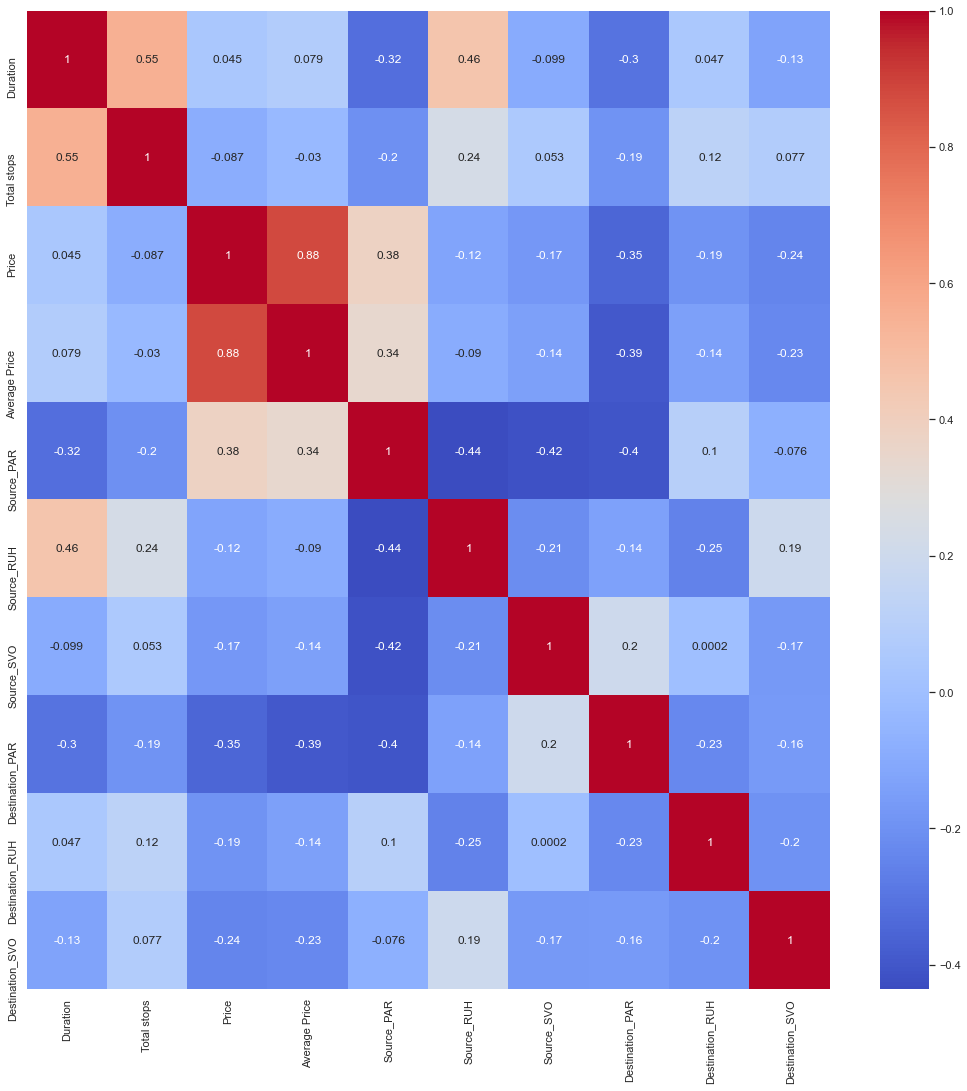

In [160]:
plt.figure(figsize = (18,18))

sns.heatmap(final_df.corr(),annot= True, cmap = "coolwarm")

plt.show()

In [161]:
# getting feature importance to the target variable "Price".
selection =ExtraTreesRegressor()
selection.fit(X,y)
selection.feature_importances_

array([0.03999422, 0.01570177, 0.74317697, 0.08991898, 0.00889242,
       0.01328784, 0.02215941, 0.05354494, 0.01332344])

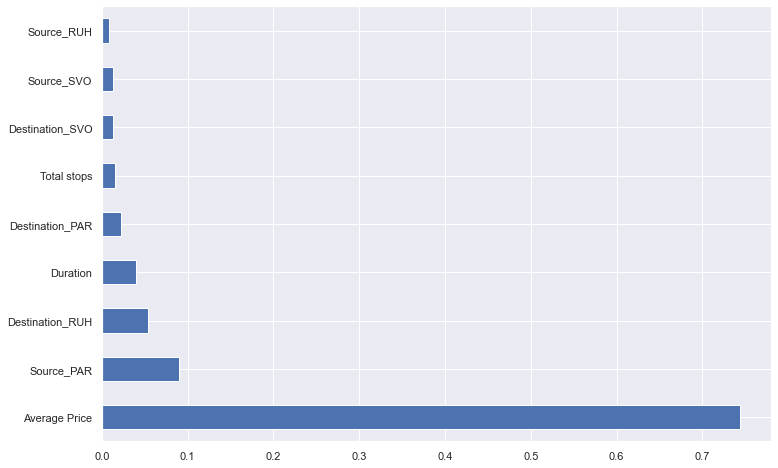

In [163]:
# plotting graph of important features
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_,index = X.columns)
feat_importances.nlargest(20).plot(kind="barh")
plt.show()

## Modeling: <a class="anchor" id="modeling"></a>

### Splitting the data

In [164]:
# 60% Train - 20% Val - 20% Test

X_train_or, X_test, y_train_or, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_or, y_train_or, test_size=0.25)

### Defining a function to get metrics for val set

In [165]:
def get_metrics(model):
    print(f'Train score {model.score(X_train, y_train)}')
    print(f'Val score {model.score(X_val, y_val)}')
    print("MAE:" , metrics.mean_absolute_error(y_val,model.predict(X_val)))
    print("MSE:" , metrics.mean_squared_error(y_val,model.predict(X_val)))
    print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_val,model.predict(X_val))))

### Baseline Linear Regression

In [167]:
lr = LinearRegression()
lr.fit(X_train, y_train)
score = lr.score(X_val, y_val)
get_metrics(lr)

Train score 0.8040357223322144
Val score 0.7891035984538434
MAE: 225.09235539537735
MSE: 152995.68380136558
RMSE: 391.14662698451787


### Polynomial 

In [168]:
for degree in [1,2,3,4,5]:
    poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly.fit(X_train, y_train)
    print("-"*20)
    print("Degree", degree)
    get_metrics(poly)

--------------------
Degree 1
Train score 0.8040357223322144
Val score 0.7891035984538438
MAE: 225.0923553953841
MSE: 152995.68380136523
RMSE: 391.14662698451747
--------------------
Degree 2
Train score 0.8569208072557248
Val score 0.8475711159764316
MAE: 179.19068173029146
MSE: 110580.17667106038
RMSE: 332.5359780099897
--------------------
Degree 3
Train score 0.8770210319280359
Val score 0.8667875960721851
MAE: 161.85095797669118
MSE: 96639.5001542935
RMSE: 310.8689436953996
--------------------
Degree 4
Train score 0.8829392209905675
Val score 0.8723399701473494
MAE: 152.20393140466717
MSE: 92611.50696843152
RMSE: 304.321387628986
--------------------
Degree 5
Train score 0.8879647071090535
Val score 0.8712998916720526
MAE: 149.72369720260875
MSE: 93366.03628409792
RMSE: 305.55856440966915


### Lasso

In [169]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
get_metrics(lasso_model)

Train score 0.8038454319902063
Val score 0.7889638512580056
MAE: 223.49066191496019
MSE: 153097.06399386658
RMSE: 391.2761991149814


### Ridge

In [170]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
get_metrics(ridge_model)

Train score 0.8040357065848055
Val score 0.7891037101749157
MAE: 225.07772121553117
MSE: 152995.6027528426
RMSE: 391.1465233807436


### ElasticNet

In [171]:
EN_model = ElasticNet(alpha=1)
EN_model.fit(X_train, y_train)
EN_model.score(X_val, y_val)
get_metrics(EN_model)

Train score 0.7895996502819659
Val score 0.7752654436876839
MAE: 224.4110277527439
MSE: 163034.6315286663
RMSE: 403.77547167784513


### Random Forest

In [172]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
get_metrics(rf)

Train score 0.9648778537711422
Val score 0.9448134490695079
MAE: 61.717733027545194
MSE: 40035.31608101726
RMSE: 200.0882707232417


### Feature Scaling

In [173]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

In [174]:
# function to get metrics for scaled features
def scaled_metrics(model):
    print(f'Train score {model.score(X_train_scaled, y_train)}')
    print(f'Val score {model.score(X_val_scaled, y_val)}')
    print("MAE:" , metrics.mean_absolute_error(y_val,model.predict(X_val_scaled)))
    print("MSE:" , metrics.mean_squared_error(y_val,model.predict(X_val_scaled)))
    print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_val,model.predict(X_val_scaled))))

    
## Baseline: Linear Regression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
score = lr.score(X_val_scaled, y_val)
print("LR")
scaled_metrics(lr)
print("-"*50)

## Polynomial

for degree in [1,2,3,4,5]:
    poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly.fit(X_train, y_train)
    print("Polynomial - Degree", degree)
    scaled_metrics(poly)
    print("-"*50)

## Lasso

lasso_model = Lasso()
lasso_model.fit(X_train_scaled, y_train)
print("Lasso")
scaled_metrics(lasso_model)
print("-"*50)

## Ridge

ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
print("Ridge")
scaled_metrics(ridge_model)
print("-"*50)

## ElasticNet

EN_model = ElasticNet(alpha=1)
EN_model.fit(X_train_scaled, y_train)
EN_model.score(X_val_scaled, y_val)
print("ElasticNet")
scaled_metrics(EN_model)
print("-"*50)

## Random Forest
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
print("Random Forest")
scaled_metrics(rf)

LR
Train score 0.8040357223322144
Val score 0.7891035984538433
MAE: 225.09235539537684
MSE: 152995.68380136567
RMSE: 391.146626984518
--------------------------------------------------
Polynomial - Degree 1
Train score -0.3079480631703013
Val score -0.3153015545186666
MAE: 756.619594657905
MSE: 954191.0590377726
RMSE: 976.8270363978326
--------------------------------------------------
Polynomial - Degree 2
Train score -6.619866701696714
Val score -6.708250742830492
MAE: 1819.2993972374343
MSE: 5591983.005236949
RMSE: 2364.737407247779
--------------------------------------------------
Polynomial - Degree 3
Train score -6.396139020230291
Val score -6.597515038614633
MAE: 1978.6373777102278
MSE: 5511649.321667562
RMSE: 2347.6902099015456
--------------------------------------------------
Polynomial - Degree 4
Train score -67.38613658531676
Val score -65.94440159195507
MAE: 5158.441261042131
MSE: 48565098.4234209
RMSE: 6968.8663657312945
--------------------------------------------------

#### Feature scaling was of no use, it did not improve anything.



**<br>From the above analysis, we can see that the random forest model performed the best with:</br>**

**Train score 0.9648778537711422**
**<br>Val score 0.9448134490695079</br>**
**<br>MAE: 61.717733027545194</br>**
**<br>MSE: 40035.31608101726</br>**
**<br>RMSE: 200.0882707232417</br>**

**So, we'll select it as our model.**

In [175]:
# retraining the random forest model on train + val, and scoring on test

X_train_val = pd.concat([X_train,X_val])
y_train_val = pd.concat([y_train,y_val])

rf = RandomForestRegressor()
rf.fit(X_train_val,y_train_val)

print(f'Train score {rf.score(X_train_val, y_train_val)}')
print(f'Test score {rf.score(X_test, y_test)}')
print("MAE:" , metrics.mean_absolute_error(y_test,rf.predict(X_test)))
print("MSE:" , metrics.mean_squared_error(y_test,rf.predict(X_test)))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,rf.predict(X_test))))

Train score 0.963236185218782
Test score 0.9458897010690771
MAE: 61.86501612022038
MSE: 40409.86746202512
RMSE: 201.02205715300278


In [176]:
y_train_val_pred = rf.predict(X_train_val)
y_test_pred = rf.predict(X_test)

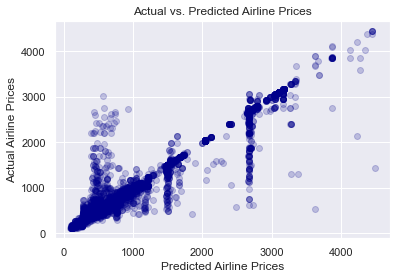

In [177]:
plt.scatter(y_test,y_test_pred,alpha =0.2,color="DarkBlue")
plt.title('Actual vs. Predicted Airline Prices')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices');

### Hyperparameter Tuning

In [178]:
# randomized search CV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

In [179]:
# create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [180]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, n_jobs = 1)

In [181]:
rf_random.fit(X_train_val,y_train_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  21.6s
[CV] END max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  21.5s
[CV] END max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  22.4s
[CV] END max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  23.0s
[CV] END max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  20.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   6.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   6.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   scoring='neg_mean_squared_error', verbose=2)

In [182]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 25}

In [183]:
prediction = rf_random.predict(X_test)

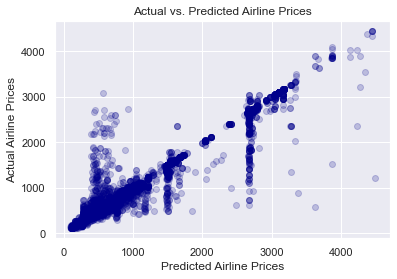

In [184]:
plt.scatter(y_test,prediction,alpha =0.2,color="DarkBlue")
plt.title('Actual vs. Predicted Airline Prices')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices');

In [185]:
print("MAE:" , metrics.mean_absolute_error(y_test,prediction))
print("MSE:" , metrics.mean_squared_error(y_test,prediction))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,prediction)))

MAE: 64.19388289923229
MSE: 41409.9342490973
RMSE: 203.49431011479732


#### Therefore, hyperparameter tuning did not improve the model

In [186]:
test_df = pd.DataFrame({
    "Predicted Price" : rf.predict(X_test),
    "Actual Price" : y_test,
}).reset_index(drop = True)

test_df

,Predicted Price,Actual Price
0,2676.530000,2676.53
1,182.571321,248.53
2,254.362293,265.07
3,447.386056,490.93
4,643.470000,643.47
...,...,...
10015,2682.130000,2682.13
10016,1605.962800,1608.00
10017,233.286587,316.00
10018,1533.600000,1533.60


## Saving The Final Model: <a class="anchor" id="model"></a>

In [190]:
# save the model
file = open('rf_flight_prediction.pkl', 'wb')
pkl.dump(rf, file)

In [191]:
# open the model
model = open('rf_flight_prediction.pkl','rb')
rf_flight_prediction = pkl.load(model)

In [196]:
print(f'R2 score {metrics.r2_score(y_test,rf_flight_prediction.predict(X_test))}')
print("MAE:" , metrics.mean_absolute_error(y_test,rf_flight_prediction.predict(X_test)))
print("MSE:" , metrics.mean_squared_error(y_test,rf_flight_prediction.predict(X_test)))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,rf_flight_prediction.predict(X_test))))

R2 score 0.9458897010690771
MAE: 61.86501612022038
MSE: 40409.86746202512
RMSE: 201.02205715300278


### Therefore, the final model is able to predict flight ticket prices within around  ≈ $61.87